## Clustering Menopausal Users by Type of Menopause:Medical/Surgical/Hysterectomy

Goal - Cluster the users based on menopausal status and symptoms they had

User selection criteria - users have recorded more than 0 days of symptoms, more than 10 symptoms, that they've entered menopause, that they don't have periods anymore. Separately looking at same but for surgical or hysterectomy (1340;40326) vs 2044 for natural)

In [1]:
import pandas as pd
import numpy as np
from pyathena import connect
from pyathena.pandas.cursor import PandasCursor
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

In [2]:
from sensorfabric.athena import athena

In [3]:
# Establish connection with the database using PyAthena.
cursor = connect(s3_staging_dir='s3://menolife-opensci/athena/',
                  schema_name='menolife',
                  cursor_class=PandasCursor,
                  work_group='amyris',
                  region_name='us-east-1'
                ).cursor()

In [4]:
%set_env AWS_PROFILE=opensci

env: AWS_PROFILE=opensci


In [5]:
db = athena(database='menolife', workgroup='amyris', offlineCache=True)

## Dataset creation

In [6]:
# Get all the symptoms.
symptoms = db.execQuery("select distinct(name) name from symptoms order by name asc", cached=True)
print(symptoms.shape)

(45, 1)


In [7]:
# Create an empty list for all the columns which are going to be the individual symptoms.
symptoms = symptoms['name'].values

## Original Query Isn't Great - Leaves in Some of the Wrong Folks

In [8]:
menopausalusers_symptoms_query = """
WITH query1 AS (
    SELECT DISTINCT healthid
    FROM onboardingpp 
    WHERE (questions = 'Let''s customize your personal health tracker!'
        OR questions = 'Choose the symptoms you deal with the most.'
        AND questions = 'How would you describe your periods?'
        AND questions = 'Are you on birth control?'
        AND questions = 'How did you enter menopause?')
        AND length(answers) > 0
        AND (
            (
            answers LIKE '%have a period anymore%'
            AND answers NOT LIKE '%IUD%'
            AND answers NOT LIKE '%Pill%'
            AND answers NOT LIKE '%Implant%'
            AND answers NOT LIKE '%Shot%'
            AND answers NOT LIKE '%Vaginal Ring%'
            AND answers NOT LIKE '%Patch%'
            )
            AND (answers LIKE '%Naturally%'
                OR answers LIKE '%Medically%'
                OR answers LIKE '%Hysterectomy%')
            
            AND (
            answers NOT LIKE '%Chemotherapy%'
            AND answers NOT LIKE 'Unpredictable'
            AND answers NOT LIKE 'Regular cycle'
            )
            OR answers NOT LIKE 'none'
        )
),
query2 AS (
    SELECT s.uid, s.name, COUNT(s.name) AS count 
    FROM symptoms s
    INNER JOIN query1 q1 ON s.uid = q1.healthid
    INNER JOIN (
        SELECT uid
        FROM symptoms_sum ss
        WHERE days_symptoms_recorded > 0
        AND ss.uid IN (SELECT healthid FROM query1)
    ) ss ON q1.healthid = ss.uid
    GROUP BY s.uid, s.name
)
SELECT q2.uid, q2.name, q2.count
FROM query2 q2
ORDER BY q2.uid, q2.count DESC;

"""

menopausalusers_symptoms = db.execQuery(menopausalusers_symptoms_query, cached=True)
print(menopausalusers_symptoms.shape)
menopausalusers_symptoms.head()

(25577, 3)


,uid,name,count
0,5f8f274466dae0d0328adb80,brittle_nails,1
1,5f8f274466dae0d0328adb80,headaches,1
2,5f8f274466dae0d0328adb80,bloating,1
3,5f90eb35a42cd9d7053ec1d5,hot_flashes,1
4,5f90eb35a42cd9d7053ec1d5,constipation,1


## Create a much simpler query based on answer to how did you enter menopause:this checks for if you report having entered menopause and if you report no periods in at least 12 months

In [9]:
## MedSurgHyst

menopausalusers_symptoms_query = """
WITH query1 AS (
    SELECT DISTINCT healthid
    FROM onboardingpp 
    WHERE (questions = 'How did you enter menopause?'
    OR questions = 'How would you describe your menstrual cycle?')
        AND length(answers) > 1
        AND (answers like '%Hysterectomy%'
        or answers like '%Medically%'
        or answers like '%Surg%' )
        AND (answers NOT LIKE '%Chemotherapy%'
                AND answers NOT LIKE '%Naturally%')
),
query2 AS (
    SELECT s.uid, s.name, COUNT(s.name) AS count 
    FROM symptompp_npt s
    INNER JOIN query1 q1 ON s.uid = q1.healthid
    INNER JOIN (
        SELECT uid
        FROM symptoms_sum ss
        WHERE days_symptoms_recorded > 0
        and symptoms_recorded >10
        and symptoms_recorded<300
        
        AND ss.uid IN (SELECT healthid FROM query1)
    ) ss ON q1.healthid = ss.uid
    GROUP BY s.uid, s.name
)
SELECT q2.uid, q2.name, q2.count
FROM query2 q2
ORDER BY q2.uid, q2.count DESC;

"""

menopausalusers_symptoms = db.execQuery(menopausalusers_symptoms_query, cached=True)
print(menopausalusers_symptoms.shape)
menopausalusers_symptoms.head()

(12945, 3)


,uid,name,count
0,5f92aeffa42cd9d7053ec1ff,mood_swings,2
1,5f92aeffa42cd9d7053ec1ff,spotting,2
2,5f92aeffa42cd9d7053ec1ff,constipation,2
3,5f92aeffa42cd9d7053ec1ff,uti,2
4,5f92aeffa42cd9d7053ec1ff,joint_pain,2


## Check the onboarding data of who actually showed up in the query

In [10]:
menopausalusers_onboarding_query = """

WITH query1 AS (
    SELECT DISTINCT healthid
    FROM onboardingpp 
    WHERE (questions = 'How did you enter menopause?'
    OR questions = 'How would you describe your menstrual cycle?')
        AND length(answers) > 1
        AND (answers like '%Hysterectomy%'
        or answers like '%Medically%'
        or answers like '%Surg%' )
        AND (answers NOT LIKE '%Chemotherapy%'
                AND answers NOT LIKE '%Naturally%')
),
query2 AS (
    SELECT s.uid, s.name, COUNT(s.name) AS count 
    FROM symptompp_npt s
    INNER JOIN query1 q1 ON s.uid = q1.healthid
    INNER JOIN (
        SELECT uid
        FROM symptoms_sum ss
        WHERE days_symptoms_recorded > 0
        and symptoms_recorded >10
        and symptoms_recorded <300
        
        AND ss.uid IN (SELECT healthid FROM query1)
    ) ss ON q1.healthid = ss.uid
    GROUP BY s.uid, s.name
)

SELECT q2.uid, o.questions, o.answers
FROM query2 q2
INNER JOIN onboardingpp o ON q2.uid = o.healthid
ORDER BY q2.uid, o.questions, q2.count DESC;

   

"""

menopausalusers_onboarding = db.execQuery(menopausalusers_onboarding_query, cached=True)
print(menopausalusers_onboarding.shape)

(57471, 3)


In [11]:
menopausalusers_onboarding.to_csv('onboarding_menopausalmedsurghyst_npt_check.csv')

In [12]:
#Is this still keeping only the correct uids? 

# Calculate the unique number of UIDs
unique_uids_count = len(menopausalusers_symptoms['uid'].unique())

# Display the unique number of UIDs
print("Unique number of UIDs:", unique_uids_count)

Unique number of UIDs: 873


## Create Dataframe of Queried Data

In [13]:
frame = pd.DataFrame()  # Empty dataframe that will contain all the dataset.
uidmap = {}
# Start breaking the users frame and extract data from it to add to the data matrix.
temp = None  # Temp dictionary that holds the symptom counts for each user.
for uid, sname, scount in zip(menopausalusers_symptoms['uid'].values, menopausalusers_symptoms['name'].values, menopausalusers_symptoms['count'].values):
    if not (uid in uidmap):
        # If temp is not None (everything except for the first uid then we will concat the last uid to the frame.
        if not (temp is None):
            temp = pd.Series(temp)
            temp = temp.to_frame().T
            frame = pd.concat([frame, temp], ignore_index=True)
        temp = {}  # Start fresh again.
        temp['uid'] = uid
        uidmap[uid] = 1
    temp[sname] = scount
frame = frame.set_index(['uid']) # Set the 'uid' as the index, so it becomes easier to query.
frame = frame.fillna(0)

In [14]:
#Note some users are still reporting ovulation and ovulation pain. Remove them 

frame = frame[(frame['ovulation'] == 0) & (frame['ovulation_pain'] == 0)]

In [15]:
#Now how many do I have left?

unique_uids = frame.index.unique().tolist()
unique_uids_size = len(unique_uids)
print("Size of unique_uids:", unique_uids_size)

Size of unique_uids: 828


In [16]:
# Calculate the unique number of UIDs

unique_uids_count = len(menopausalusers_symptoms['uid'].unique())
print("Unique number of UIDs:", unique_uids_count)

Unique number of UIDs: 873


In [17]:
frame.to_csv('menopausalsymptomsmedhyst_npt.csv')

In [18]:
frame.head()

,mood_swings,spotting,constipation,uti,joint_pain,painful_intercourse,headaches,anxiety,fatigue,hot_flashes,...,depression,ovulation_pain,chills,vomiting,vertigo,nipple_discharge,yeast_infection,breast_swelling,breast_pain,ovulation
uid,,,,,,,,,,,,,,,,,,,,,
5f92aeffa42cd9d7053ec1ff,2,2,2,2,2,2,2,2,2,2,...,0,0,0,0,0,0,0,0,0,0
5f9c64c2d01db71874617ca9,1,0,0,0,1,1,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
5fa1f86a997df843234093a4,0,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5fa422b2ddf60b5363e3e8d8,1,0,1,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
5fa5af262e64715d8533de46,0,0,2,0,1,0,1,0,1,2,...,0,0,0,0,0,0,0,0,0,0


In [19]:
frame.shape

(828, 45)

In [20]:
frame=frame.astype(int)

In [21]:
data_type = frame[symptoms].dtypes
#print(data_type)


In [22]:
#How Many Total Symptoms, Plot Common Symptoms by Count and by % User
# How many total symptoms

total_symptom_count = frame.sum().sum()
print("Total count of all symptoms:", total_symptom_count)


Total count of all symptoms: 21962


## One Hot Encoding for Network Analysis

In [23]:
encoding = frame.copy(deep=True)

In [24]:
encoding

,mood_swings,spotting,constipation,uti,joint_pain,painful_intercourse,headaches,anxiety,fatigue,hot_flashes,...,depression,ovulation_pain,chills,vomiting,vertigo,nipple_discharge,yeast_infection,breast_swelling,breast_pain,ovulation
uid,,,,,,,,,,,,,,,,,,,,,
5f92aeffa42cd9d7053ec1ff,2,2,2,2,2,2,2,2,2,2,...,0,0,0,0,0,0,0,0,0,0
5f9c64c2d01db71874617ca9,1,0,0,0,1,1,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
5fa1f86a997df843234093a4,0,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5fa422b2ddf60b5363e3e8d8,1,0,1,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
5fa5af262e64715d8533de46,0,0,2,0,1,0,1,0,1,2,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
640976a04c33a20028c6002f,0,0,0,0,0,0,0,0,0,8,...,0,0,0,0,0,0,0,0,0,0
640a169d4c33a20028c60216,0,0,0,0,0,0,0,0,0,54,...,0,0,0,0,0,0,0,0,0,0
640c97374c33a20028c60865,0,0,0,0,0,0,2,0,4,1,...,0,0,0,0,0,0,0,0,0,0


In [25]:
def replace_map(x):
    if x > 0:
        return 1
    else:
        return 0

In [26]:
encoding=encoding.applymap(replace_map)

In [27]:
# Save this into a csv file so we can use it from inside R.
encoding.to_csv('symptoms_menopause_medhyst_npt_onehot.csv', index=False)

## Back to Symptom Analysis

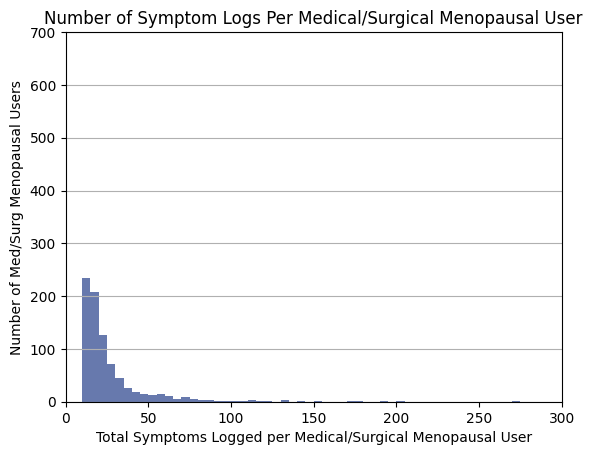

Median Symptoms per User: 19.0
Median Absolute Deviation (MAD) of Symptoms per User: 6.0


In [28]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you already have the 'frame' dataframe with symptom counts

# Total symptom count for each UID
total_symptom_count_per_uid = frame.sum(axis=1)

# Calculate the total symptoms per user
total_symptoms_per_user = total_symptom_count_per_uid.values

# Calculate the median and median absolute deviation
median_symptoms_per_user = np.median(total_symptoms_per_user)
mad_symptoms_per_user = np.median(np.abs(total_symptoms_per_user - median_symptoms_per_user))


# Create histogram with specified bins
bins = range(0, max(total_symptoms_per_user) + 5, 5)

plt.hist(total_symptoms_per_user, bins=bins, edgecolor='none', alpha=0.7,color=(39/255,64/255,139/255))
plt.xlabel('Total Symptoms Logged per Medical/Surgical Menopausal User')
plt.ylabel('Number of Med/Surg Menopausal Users')
plt.title('Number of Symptom Logs Per Medical/Surgical Menopausal User')
plt.grid(axis='y')
plt.ylim(0,700) #note it goes up to about 2500
plt.xlim(0, 300) #note some rando users log >500 symptoms. Should we omit them?
plt.show()

print("Median Symptoms per User:", median_symptoms_per_user)
print("Median Absolute Deviation (MAD) of Symptoms per User:", mad_symptoms_per_user)

In [29]:
# Symptom Frequency by % of total symptoms, for each symptom

# Step 1: Calculate the total count of each symptom type (sum across columns)
symptom_totals = frame.sum(axis=0)

# Step 2: Calculate the total count of all symptoms
total_symptom_count = symptom_totals.sum()

# Step 3: Calculate the percentage of each symptom type's count relative to the total count of all symptoms
symptom_percentages = (symptom_totals / total_symptom_count) * 100

# Step 4: Sort the symptom_percentages in descending order (most frequent to least frequent)
symptom_percentages_sorted = symptom_percentages.sort_values(ascending=False)

# Step 5: Print out each symptom type and its corresponding percentage in the sorted order
for symptom, count in zip(symptom_percentages_sorted.index, symptom_percentages_sorted.values):
   print(f"{symptom}: {count:.2f}%")

hot_flashes: 14.39%
fatigue: 5.75%
anxiety: 4.62%
night_sweats: 4.02%
headaches: 3.71%
joint_pain: 3.66%
brain_fog: 3.60%
bloating: 3.41%
insomnia: 3.21%
dry_skin: 3.15%
mood_swings: 2.97%
dry_eyes: 2.91%
depression: 2.90%
allergies: 2.89%
muscle_tension: 2.65%
itchy_skin: 2.45%
sex_drive: 2.34%
facial_hair: 2.33%
brittle_nails: 2.25%
memory_lapse: 2.08%
hair_loss: 1.88%
chills: 1.83%
dizzy: 1.77%
constipation: 1.76%
vaginal_dryness: 1.66%
ringing_ears: 1.64%
tingling_extremeties: 1.61%
breast_pain: 1.40%
incontinence: 1.39%
heartburn: 1.37%
nausea: 1.25%
irregular_beat: 1.09%
diarrhea: 1.05%
odor: 0.99%
cramps: 0.79%
painful_intercourse: 0.75%
vertigo: 0.71%
breast_swelling: 0.58%
uti: 0.46%
yeast_infection: 0.27%
spotting: 0.24%
vomiting: 0.16%
nipple_discharge: 0.08%
ovulation_pain: 0.00%
ovulation: 0.00%


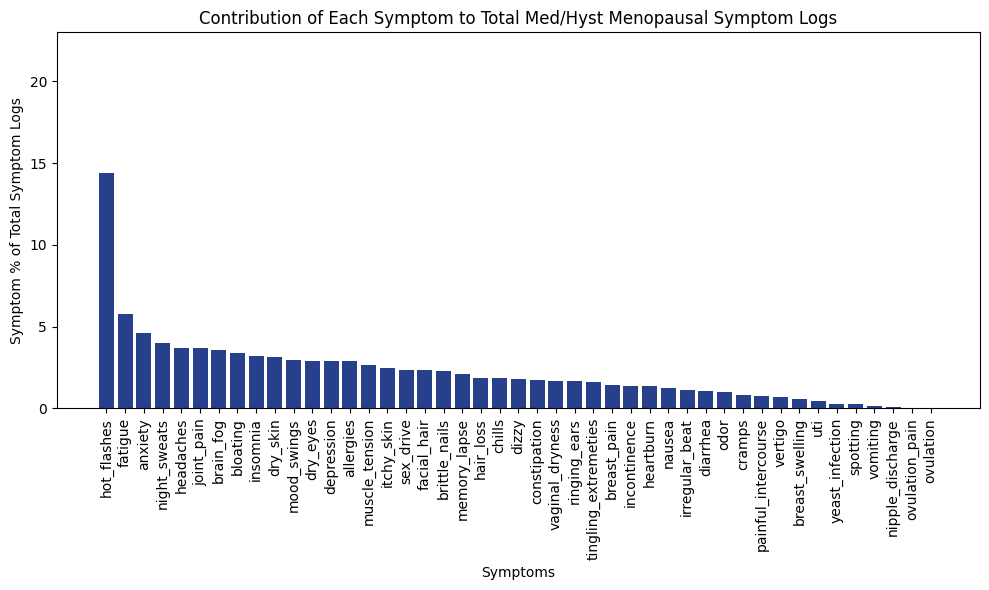

In [72]:
symptom_percentages_sorted = symptom_percentages.sort_values(ascending=False)

plt.figure(figsize=(10, 6))  # Set the figure size for better visibility
plt.bar(symptom_percentages_sorted.index, symptom_percentages_sorted.values,color=(39/255,64/255,139/255))
plt.xlabel("Symptoms")
plt.ylabel("Symptom % of Total Symptom Logs")
plt.ylim(0, 23)
plt.title("Contribution of Each Symptom to Total Med/Hyst Menopausal Symptom Logs")
plt.xticks(rotation=90)  # Rotate the x-axis labels for better readability
plt.tight_layout()  # Adjust the layout to prevent cropping of labels
plt.show()

In [73]:
# Step 1: Calculate the total number of users
total_users = len(frame)

# Step 2: Calculate the percentage of users who have each symptom
symptom_percentages = (frame.astype(bool).sum() / total_users) * 100

print(symptom_percentages.sort_values(ascending=False))

fatigue                 80.797101
hot_flashes             69.806763
anxiety                 61.352657
brain_fog               60.024155
joint_pain              58.454106
headaches               54.589372
bloating                53.864734
insomnia                53.743961
night_sweats            51.932367
mood_swings             50.724638
depression              49.637681
dry_skin                48.792271
memory_lapse            45.289855
muscle_tension          45.289855
sex_drive               44.565217
itchy_skin              43.357488
facial_hair             39.855072
allergies               39.251208
brittle_nails           38.526570
dry_eyes                38.164251
hair_loss               35.990338
constipation            34.420290
vaginal_dryness         30.676329
tingling_extremeties    30.314010
dizzy                   29.710145
ringing_ears            26.932367
heartburn               26.570048
incontinence            24.275362
nausea                  21.739130
chills        

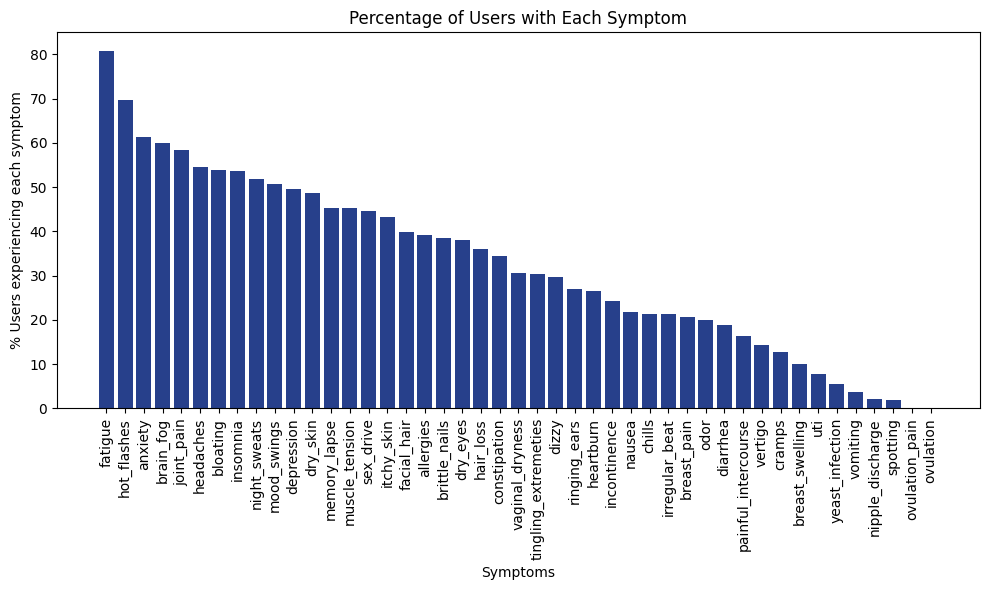

In [74]:
symptom_percentages_sorted = symptom_percentages.sort_values(ascending=False)

plt.figure(figsize=(10, 6))  # Set the figure size for better visibility
plt.bar(symptom_percentages_sorted.index, symptom_percentages_sorted.values,color=(39/255,64/255,139/255))
plt.xlabel("Symptoms")
plt.ylabel("% Users experiencing each symptom")
plt.ylim(0,85)
plt.title("Percentage of Users with Each Symptom")
plt.xticks(rotation=90)  # Rotate the x-axis labels for better readability
plt.tight_layout()  # Adjust the layout to prevent cropping of labels
plt.show()

## Covariance matrix of the features

Standardize the features first.

In [124]:
sframe = frame[symptoms].astype('int64')
sframe = (sframe - sframe.mean()) / sframe.std()

In [131]:
frame[symptoms]

,allergies,anxiety,bloating,brain_fog,breast_pain,breast_swelling,brittle_nails,chills,constipation,cramps,...,painful_intercourse,ringing_ears,sex_drive,spotting,tingling_extremeties,uti,vaginal_dryness,vertigo,vomiting,yeast_infection
uid,,,,,,,,,,,,,,,,,,,,,
5f92aeffa42cd9d7053ec1ff,1,2,2,1,0,0,1,0,2,0,...,2,0,2,2,0,2,2,0,0,0
5f9c64c2d01db71874617ca9,0,1,0,1,0,0,0,0,0,0,...,1,0,1,0,0,0,1,0,0,0
5fa1f86a997df843234093a4,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
5fa422b2ddf60b5363e3e8d8,0,0,0,1,0,0,0,0,1,0,...,0,1,1,0,1,0,1,0,0,0
5fa5af262e64715d8533de46,0,0,2,3,0,0,1,0,2,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
640976a04c33a20028c6002f,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
640a169d4c33a20028c60216,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
640c97374c33a20028c60865,0,0,1,2,0,0,0,0,0,0,...,0,2,0,0,0,0,1,0,0,0


## Visualizing the distribution of some of the syptoms

Hotflashes

/home/ubuntu/anaconda3/envs/menolife/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning:

The figure layout has changed to tight



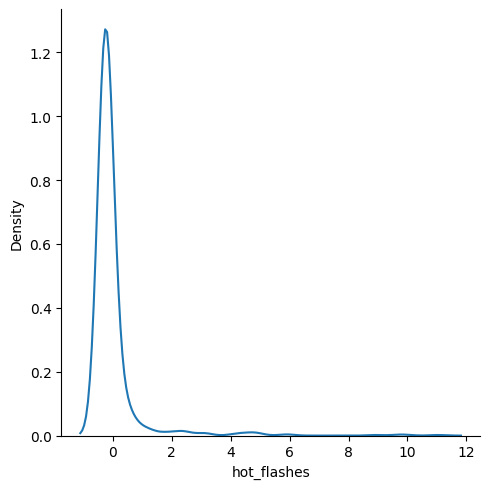

In [76]:
sns.displot(sframe, x='hot_flashes', kind='kde')

/home/ubuntu/anaconda3/envs/menolife/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


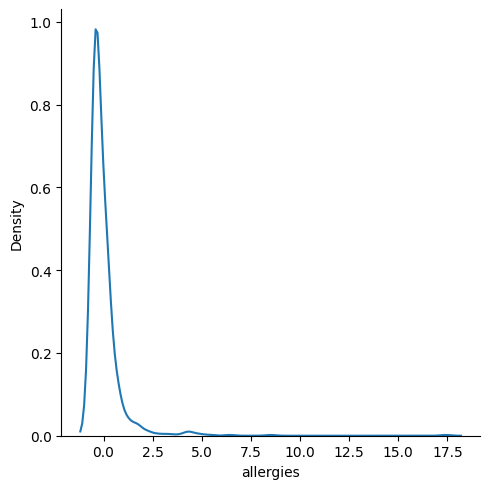

In [38]:
sns.displot(sframe, x='allergies', kind='kde')

In [77]:
cmatrix = sframe.cov()

In [78]:
#cmatrix = sframe_by_symptom.cov()

# List of symptom names to remove
symptoms_to_remove = ["ovulation", "ovulation_pain"]

# Step 1: Drop the specified rows and columns from the covariance matrix
cmatrix = cmatrix.drop(symptoms_to_remove, axis=0).drop(symptoms_to_remove, axis=1)

# Step 2: Print the filtered covariance matrix
#print(filtered_cmatrix)


In [79]:
cmatrix.to_csv('menopause_medicalhysterectomy_npt_symptom_covariance.csv', index=True)

In [80]:
fig = px.imshow(cmatrix, 
                width=2000, 
                height=1024, 
                text_auto=True, 
                aspect='auto',
                title='Symptom Covariance')
fig.show()
# Also go ahead and save this figure.
fig.write_image('menopause_medhyst_npt_symptom_covariance.png')

### Notes

1. I find it interesting that covariance of all other features with Hotflahses is extremely low, except for Nightsweats. Could this mean that an increasing number of hotflash reporting is associated with an increasein the number of nightsweats reporting.

## Find pairs of symptoms with more than 60% corelation.

In [82]:
th=0.60

# Filter the covariance matrix based on the threshold
fmatrix = cmatrix[cmatrix >= th]

# Create a list of symptom pairs with their covariance values
covariance_list = []
for s in symptoms:
    if s not in ['ovulation', 'ovulation_pain']:
        paired = fmatrix[s].dropna().index.values
        for p in paired:
            if not (s == p):
                covariance = fmatrix.loc[s][p]
                covariance_list.append((s, p, covariance))

# Sort the list in descending order based on covariance values
sorted_covariance_list = sorted(covariance_list, key=lambda x: x[2], reverse=True)

# Print symptom pairs and their covariance values
for s1, s2, covariance in sorted_covariance_list:
    print('{} - {} - {}'.format(s1, s2, covariance))


facial_hair - itchy_skin - 0.679363874584502
itchy_skin - facial_hair - 0.679363874584502
facial_hair - vaginal_dryness - 0.6171286441578443
vaginal_dryness - facial_hair - 0.6171286441578443
chills - irregular_beat - 0.607517828531197
irregular_beat - chills - 0.607517828531197
itchy_skin - vaginal_dryness - 0.602836900231947
vaginal_dryness - itchy_skin - 0.602836900231947


## Cluster Map

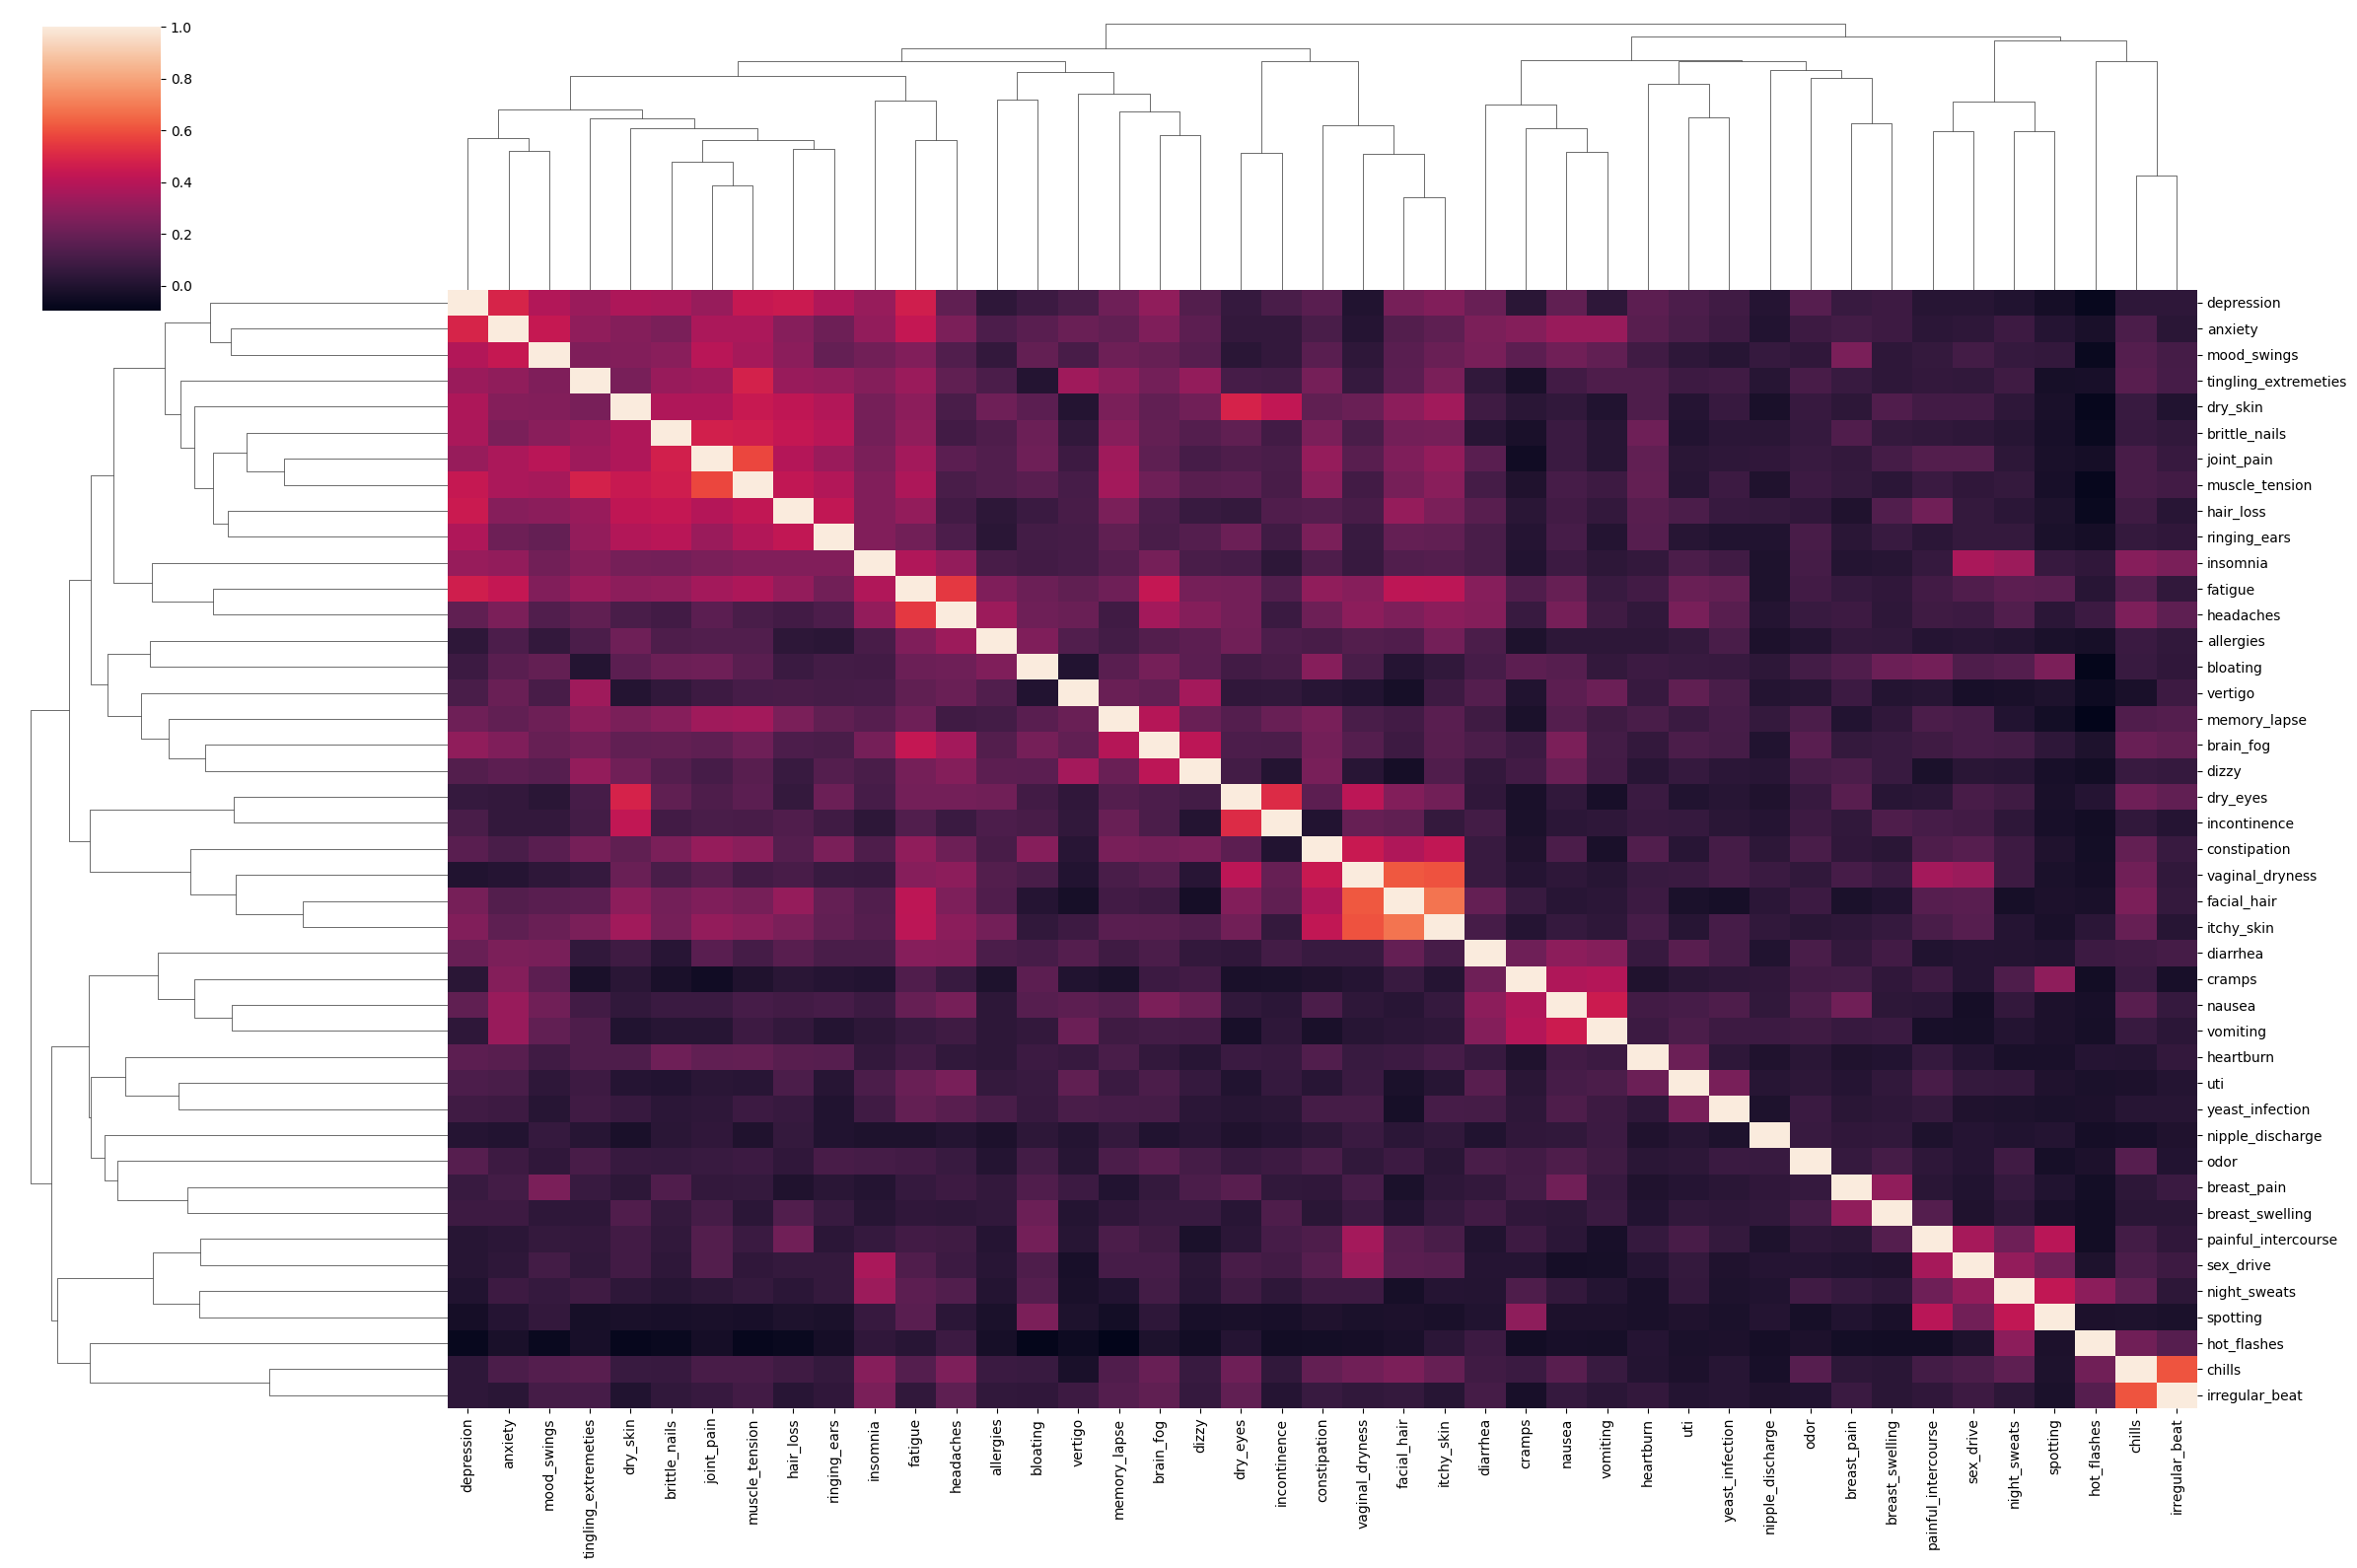

In [83]:
hcluster = sns.clustermap(cmatrix, figsize=(24, 16))

In [84]:
hcluster.savefig('symptom_co_hirach_menopausal_medicalhyst_npt.png')

In [85]:
# Step 1:  extract clustering labels
clustering_labels = hcluster.dendrogram_row.reordered_ind

# Step 2: Calculate ARI for different numbers of clusters (k)
max_clusters = 10  # Choose the maximum number of clusters to evaluate
ari_scores = []

for k in range(2, max_clusters + 1):
    # Replace 'KMeans' with your preferred clustering algorithm (e.g., DBSCAN)
    kmeans = KMeans(n_clusters=k, n_init=50, random_state=42)
    predicted_labels = kmeans.fit_predict(cmatrix)
    ari = adjusted_rand_score(clustering_labels, predicted_labels)
    ari_scores.append(ari)
    print(f"ARI for k={k}: {ari:.4f}")

# Step 3: Find the optimal number of clusters based on the ARI scores
optimal_k = ari_scores.index(max(ari_scores)) + 2  # Add 2 to account for k=2 being the starting value

print("Optimal number of clusters:", optimal_k)

# Use the optimal number of clusters for visualization or further analysis
# For example, you can run k-means again with optimal_k and plot the results.

ARI for k=2: 0.0000
ARI for k=3: 0.0000
ARI for k=4: 0.0000
ARI for k=5: 0.0000
ARI for k=6: 0.0000
ARI for k=7: 0.0000
ARI for k=8: 0.0000
ARI for k=9: 0.0000
ARI for k=10: 0.0000
Optimal number of clusters: 2


In [86]:
#Let's use silhouette score instead here. 
import numpy as np
import pandas as pd
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
import seaborn as sns

# Get the cluster assignments from the Seaborn plot
cluster_assignments = hcluster.dendrogram_row.reordered_ind

# Convert the cluster assignments to a NumPy array
cluster_assignments = np.array(cluster_assignments)

# Calculate the silhouette scores for different numbers of clusters
max_clusters = 10  # Set a reasonable maximum number of clusters to consider
silhouette_scores = []

for num_clusters in range(2, max_clusters + 1):
    # Perform hierarchical clustering with 'num_clusters'
    cluster_model = AgglomerativeClustering(n_clusters=num_clusters, linkage='ward')
    cluster_model.fit(cmatrix)
    
    # Calculate the silhouette score for the current number of clusters
    score = silhouette_score(cmatrix, cluster_model.labels_)
    silhouette_scores.append(score)

# Find the optimal number of clusters that maximizes the silhouette score
optimal_num_clusters = np.argmax(silhouette_scores) + 2  # Adding 2 because range starts from 2

print("Optimal number of clusters:", optimal_num_clusters)

Optimal number of clusters: 10


## Perform PCA analysis on the data.

In [87]:
from sklearn.decomposition import PCA

In [88]:
pca = PCA(n_components=15, svd_solver='full')
X = frame[symptoms]

In [89]:
pca.fit(X)

PCA(n_components=15, svd_solver='full')

In [90]:
evariance = pca.explained_variance_ratio_
cvariance = np.cumsum(evariance)

The variance from the various features is -

In [91]:
for i,v,c in zip(range(1, evariance.size+1), evariance, cvariance):
    print('PCA{} - {:.2f}, {:.2f}'.format(i, v, c))

PCA1 - 0.67, 0.67
PCA2 - 0.08, 0.74
PCA3 - 0.03, 0.77
PCA4 - 0.03, 0.80
PCA5 - 0.02, 0.82
PCA6 - 0.02, 0.84
PCA7 - 0.02, 0.86
PCA8 - 0.01, 0.87
PCA9 - 0.01, 0.89
PCA10 - 0.01, 0.90
PCA11 - 0.01, 0.90
PCA12 - 0.01, 0.91
PCA13 - 0.01, 0.92
PCA14 - 0.01, 0.92
PCA15 - 0.01, 0.93


Looks like we would need just 3 principal components if we wanted to keep 90% of the variance. \
However the 2 components account for the majority of variance (96%).

In [92]:
pcacomponents = pca.fit_transform(X)

In [93]:
pcacomponents.shape

(828, 15)

In [94]:
# Get the impact of each feature on principal component.
impact = pca.components_.T
impact = pd.DataFrame(impact, index=symptoms, columns=pca.get_feature_names_out())

In [95]:
px.imshow(impact, 
          width=512,
          height=700,
          aspect='auto',
          title='Feature impact on principal component')

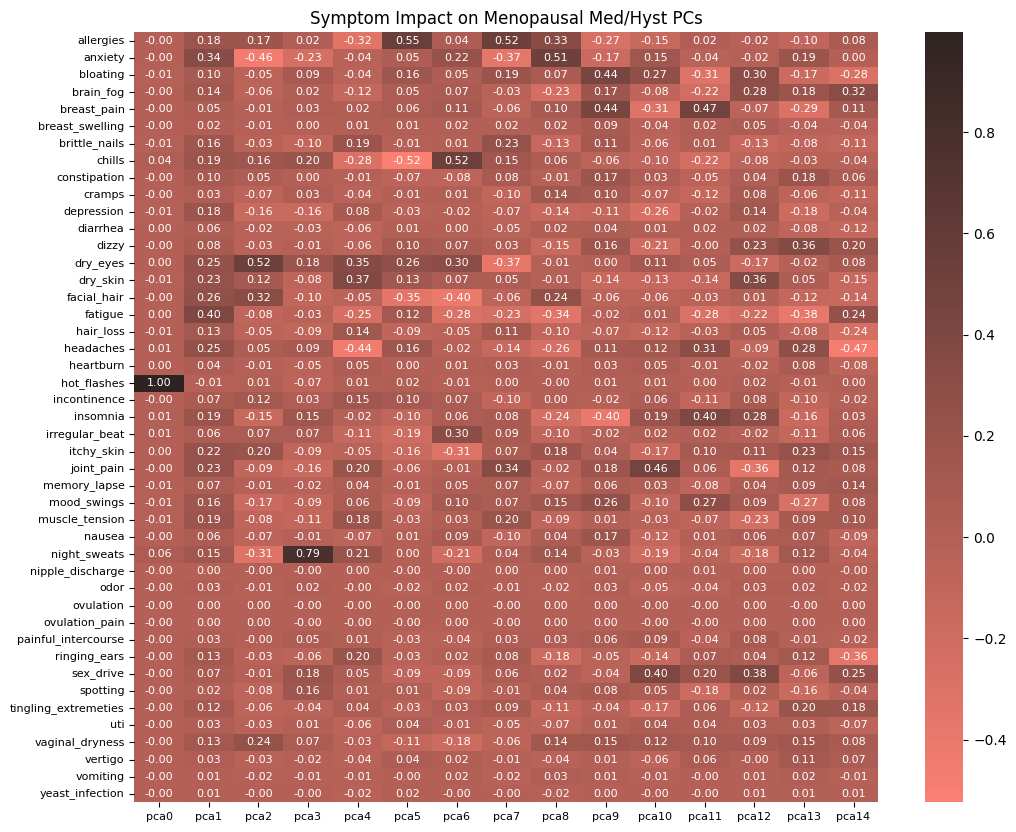

In [108]:
#Alt plot that shows every row label

import matplotlib.pyplot as plt
import seaborn as sns

# Create a light palette with the color 'seagreen'
cmap=sns.color_palette("dark:salmon_r", as_cmap=True)

# Assuming you already have the impact DataFrame 'impact' from your code
# impact = pd.DataFrame(impact, index=symptoms, columns=pca.get_feature_names_out())

# Create a heatmap using the custom colormap
plt.figure(figsize=(12, 10))
sns.heatmap(impact, cmap=cmap, annot=True, fmt=".2f", annot_kws={"size": 8})

# Adjust the font size of x-axis and y-axis tick labels
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

# Set the title and adjust its font size
plt.title('Symptom Impact on Menopausal Med/Hyst PCs', fontsize=12)

plt.show()


For the clustering we just pick the components that give 80% variance

In [109]:
pca = PCA(n_components=10, svd_solver='full')
pcacomponents = pca.fit_transform(X)
pcacomponents.shape

(828, 10)

In [110]:
from sklearn.cluster import KMeans

## Determining the optimal cluster size.

### Elbow Method

In [111]:
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,
}

# A list holds the SSE values for each k
sse = []
for k in range(1, 20):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(pcacomponents)
    sse.append(kmeans.inertia_)

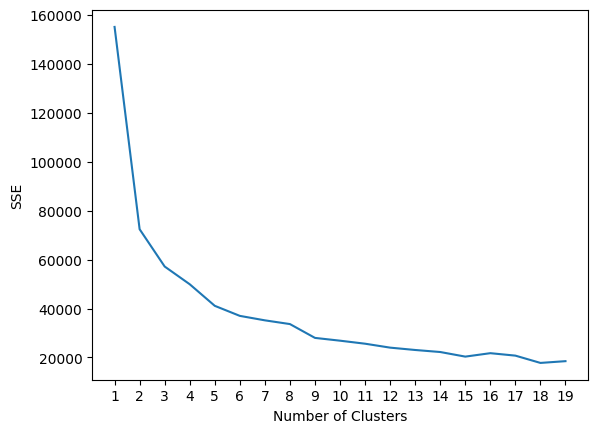

In [112]:
plt.plot(range(1, 20), sse)
plt.xticks(range(1, 20))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [113]:
from kneed import KneeLocator

kl = KneeLocator(
    range(1, 20), sse, curve="convex", direction="decreasing"
)

kl.knee

5

Conclusion - Based on the elbow method, it looks like the optimal number of clusters would be **6**

### Silhouette Coefficient

Is a measure of cluster cohesion and separation. It quantifies how well a data point fits into its assigned cluster based on two factors:
* How close the data point is to other points in the cluster
* How far away the data point is from points in other clusters

Silhouette coefficient values range between -1 and 1. Larger numbers indicate that samples are closer to their clusters than they are to other clusters.

In [114]:
from sklearn.metrics import silhouette_score

# A list holds the silhouette coefficients for each k
silhouette_coefficients = []

# Notice you start at 2 clusters for silhouette coefficient
for k in range(2, 20):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(pcacomponents)
    score = silhouette_score(pcacomponents, kmeans.labels_)
    silhouette_coefficients.append(score)

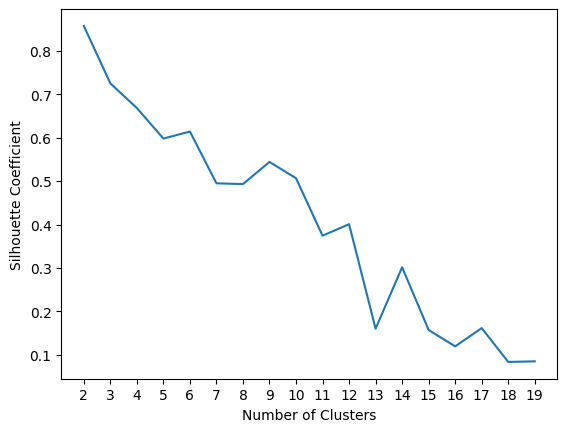

In [115]:
plt.plot(range(2, 20), silhouette_coefficients)
plt.xticks(range(2, 20))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

Conclusion - From silhouette coeff it looks like the score is maximized for n=6. We will pick n=6 based on the elbow method + S method.

## Cluster them using k-means clustering

In [116]:
kmeans = KMeans(n_clusters=5, **kmeans_kwargs)
kmeans.fit(pcacomponents)
labels = kmeans.labels_
unq = np.unique(labels)
for u in unq:
    print('{} - {}'.format(u, np.argwhere(labels == u).size))

0 - 67
1 - 5
2 - 23
3 - 711
4 - 22


## Get the users which belong to each of these clusters

In [117]:
user_segments = [[] for i in range(0, unq.size)]

for (i, uid) in enumerate(X.index.values):
    user_segments[labels[i]] += [uid]

## Find the top 5 symptoms reported by frequency for each of these segments.

In [118]:
def getTopSymptoms(users, top=10):
    # Create the where statement that will be used to filter by these users.
    where_query = "uid = '{}'".format(users[0])
    for i in range(1, len(users)):
        where_query += " or uid = '{}'".format(users[i])
        
    query = """
        select name, count(name) occ from symptoms 
            where {where}
            group by name
            order by occ desc
            limit {top}
    """.format(where=where_query, top=top)
    
    results = db.execQuery(query, cached=True)
    
    return results

In [119]:

## If the block above throws an error - use this. 
def getTopSymptoms(users, top=5):
    if len(users) == 0:
        return pd.DataFrame(columns=['name', 'occ'])  # Return an empty DataFrame if no users in the segment
    
    where_query = "uid IN ('{}')".format("','".join(users))
    
    query = """
        SELECT name, COUNT(name) AS occ FROM symptoms 
        WHERE {where}
        GROUP BY name
        ORDER BY occ DESC
        LIMIT {top}
    """.format(where=where_query, top=top)
    
    results = db.execQuery(query, cached=True)
    return results


In [120]:
segments = [[] for i in range(0, unq.size)]

for (i, segment) in enumerate(user_segments):
    result = getTopSymptoms(segment)
    segments[i] = result['name'].values

In [121]:
for (i,s) in enumerate(segments):
    print('Segment {}'.format(i))
    print(s)

Segment 0
['hot_flashes' 'night_sweats' 'fatigue' 'insomnia' 'anxiety']
Segment 1
['hot_flashes' 'chills' 'night_sweats' 'irregular_beat' 'dry_eyes']
Segment 2
['anxiety' 'fatigue' 'allergies' 'headaches' 'dry_eyes']
Segment 3
['fatigue' 'hot_flashes' 'anxiety' 'brain_fog' 'joint_pain']
Segment 4
['hot_flashes' 'night_sweats' 'fatigue' 'chills' 'headaches']


Summary of cohort symptoms -

PCA + Clustering was able to isolate the users into 4 clusters based on the occurance of their symptom reporting.a

## Alternatively if we use n=3 for segmentation

In [ ]:
kmeans = KMeans(n_clusters=3, **kmeans_kwargs)
kmeans.fit(pcacomponents)
labels = kmeans.labels_
unq = np.unique(labels)
for u in unq:
    print('{} - {}'.format(u, np.argwhere(labels == u).size))
    
user_segments = [[] for i in range(0, unq.size)]

for (i, uid) in enumerate(X.index.values):
    user_segments[labels[i]] += [uid]
    
segments = [[] for i in range(0, unq.size)]

for (i, segment) in enumerate(user_segments):
    result = getTopSymptoms(segment)
    segments[i] = result['name'].values
    
for (i,s) in enumerate(segments):
    print('Segment {}'.format(i))
    print(s)

0 - 20
1 - 3335
2 - 114
Segment 0
['hot_flashes' 'night_sweats' 'fatigue' 'insomnia' 'joint_pain']
Segment 1
['hot_flashes' 'fatigue' 'joint_pain' 'bloating' 'anxiety']
Segment 2
['hot_flashes' 'night_sweats' 'joint_pain' 'fatigue' 'allergies']
